## Capstone Two: Modeling

#### Renewable Energy in the USA from 1965 to 2022 : Hydropower, Wind, Solar, Biofuel & Geothermal Renewable Energy Dataset
### Which type of renewable energy source is expected to grow the most in the next decade in the United States?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Opening the data
df = pd.read_csv("merged_usa_dataset.csv")

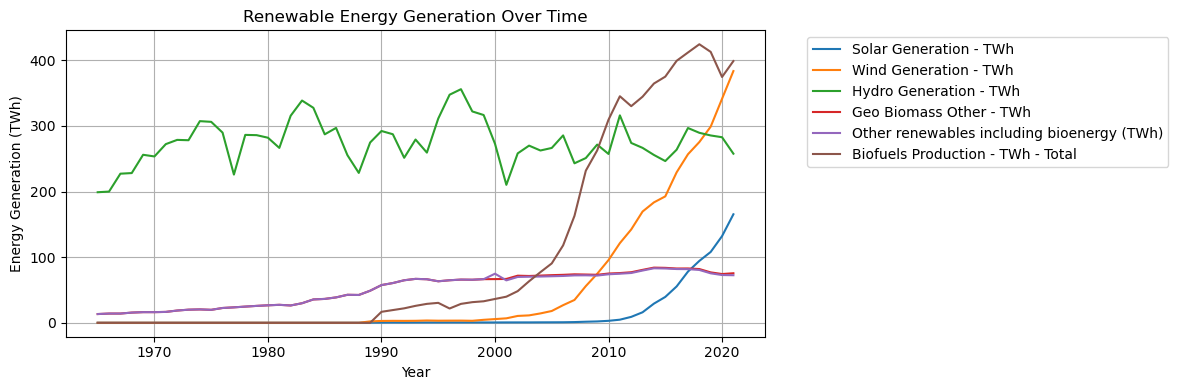

In [3]:
# Extracting year and renewable energy generation columns while renaming them
renewable_columns = [
    "Year",
    "Solar Generation - TWh",
    "Wind Generation - TWh",
    "Hydro Generation - TWh",
    "Geo Biomass Other - TWh",
    "Other renewables including bioenergy (TWh)",
    "Biofuels Production - TWh - Total"
]

# Plotting time series of different renewable energy sources
plt.figure(figsize=(12, 4)) 

for column in renewable_columns[1:]:
    plt.plot(df["Year"], df[column], label=column)

plt.xlabel("Year")
plt.ylabel("Energy Generation (TWh)")
plt.title("Renewable Energy Generation Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() 
plt.show()

The data reveals that the significant growth in renewable energy sources predominantly began in 1990 and continued thereafter. Therefore, it would be more meaningful to focus on data from 1990 onwards.

In [4]:
# Trimming data to start from 1990
data_1990_onwards = df[df["Year"] >= 1990].copy()
data_1990_onwards = data_1990_onwards[renewable_columns]
data_1990_onwards.reset_index(drop=True, inplace=True)

### Percentage change

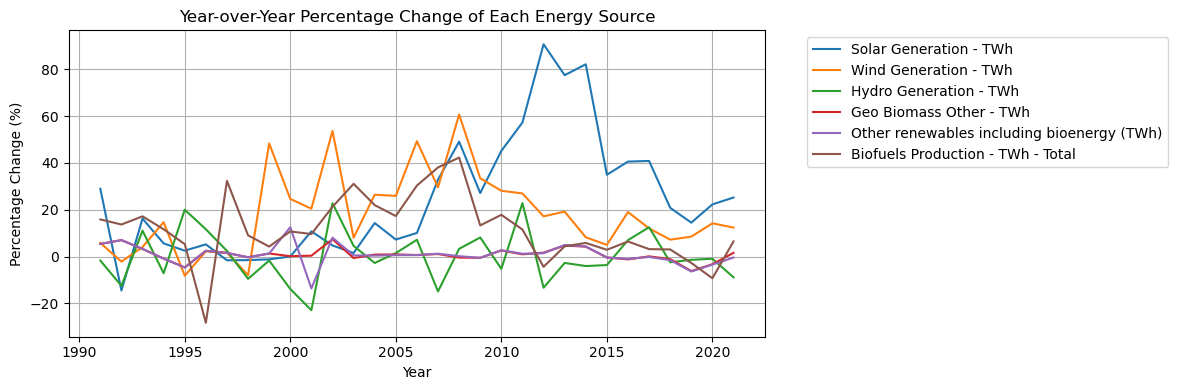

,Solar Generation - TWh,Wind Generation - TWh,Hydro Generation - TWh,Geo Biomass Other - TWh,Other renewables including bioenergy (TWh),Biofuels Production - TWh - Total,Year
1,28.980424,5.821957,-1.695246,5.381971,5.381971,15.873017,1991
2,-14.512914,-2.149412,-12.494639,7.041338,7.041338,13.698631,1992
3,16.220694,4.097073,11.067000,3.254328,3.254328,17.187800,1993
4,5.621436,14.680889,-7.129662,-0.851494,-0.851494,11.661329,1994
5,2.510357,-8.205600,20.003956,-4.656449,-4.656449,5.330895,1995


In [5]:
# Calculating the year-over-year percentage change for each energy source
data_pct_change = data_1990_onwards.iloc[:, 1:].pct_change().dropna() * 100  # dropping the first row as it will be NaN
data_pct_change['Year'] = data_1990_onwards['Year'].iloc[1:].values  # adding the Year column back

plt.figure(figsize=(12,4))

for col in data_pct_change.columns[:-1]:
    plt.plot(data_pct_change['Year'], data_pct_change[col], label=col)

plt.title('Year-over-Year Percentage Change of Each Energy Source')
plt.xlabel('Year')
plt.ylabel('Percentage Change (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() 
plt.show()

data_pct_change.head()

---

<div class="span5 alert alert-info">
<b>The predictive models for various energy types in the United States over the next decade suggest a diverse future landscape.</b><br><br>
To select and comprehend the most suitable model for exploring which energy resource will experience the greatest growth in the coming decade, each model will provide the following key metrics: Mean Absolute Error (MAE), Root Mean Square Error (RMSE), the latest recorded value, the predicted value, growth percentage, Compound Annual Growth Rate (CAGR), and Sum of Squared Residuals (SSR). <br><br>
Furthermore, all model plots feature solid lines representing the actual observed data, dashed lines indicating the forecasted values for the test set period (model validation period), and dotted lines projecting forecasted values for the next decade (2022-2031).
</div>

---

## MODEL 1: Linear regression with machine learning

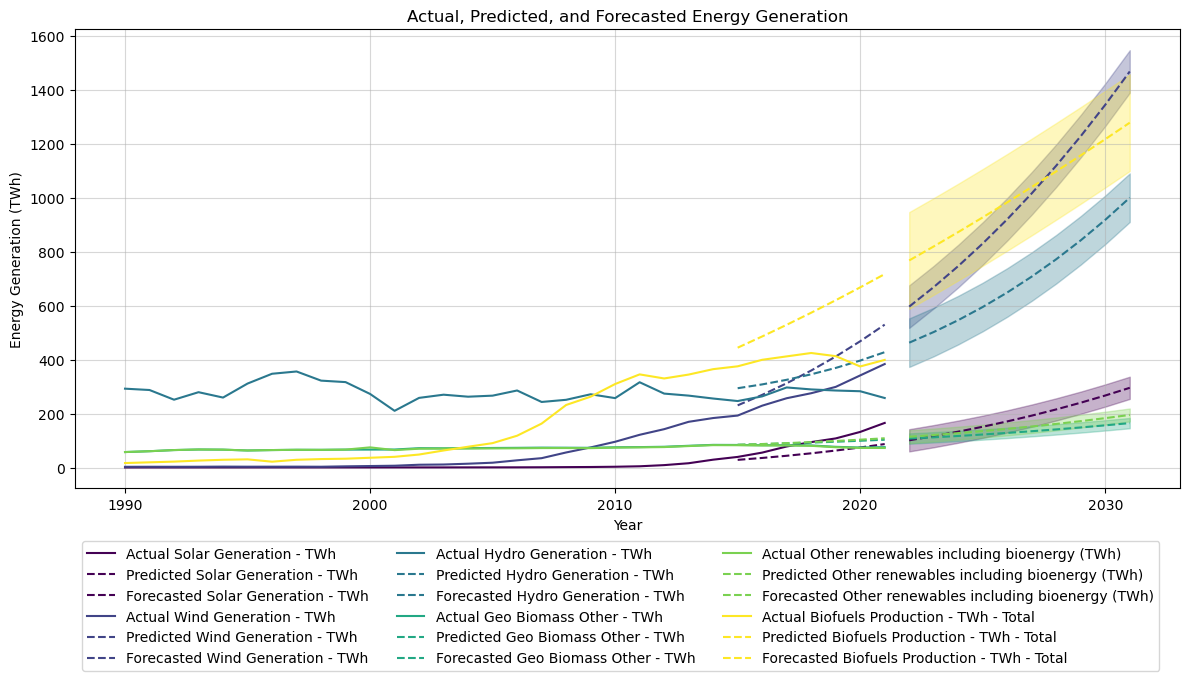

,Energy Source,MAE,RMSE,Last Value,Predicted Value,Percentage Change,CAGR,SSR
0,Solar Generation - TWh,41.072520,46.127036,165.356570,295.471952,78.687761,[5.976477627578203],14893.924156
1,Wind Generation - TWh,86.051636,94.982775,383.603270,1467.535993,282.566080,[14.35907821745943],63152.092468
2,Hydro Generation - TWh,77.599761,90.154249,257.690100,999.850794,288.005125,[14.520634658564724],56894.520744
3,Geo Biomass Other - TWh,13.376400,16.556590,75.490265,164.698720,118.172131,[8.113500039734788],1918.844633
4,Other renewables including bioenergy (TWh),17.031908,20.943639,72.490000,194.964267,168.953327,[10.399648868003153],3070.452243
5,Biofuels Production - TWh - Total,177.136852,199.320174,398.846950,1277.788069,220.370525,[12.347976655701999],278099.723336


In [6]:
# Renewable energy columns
renewable_columns = [
    "Year",
    "Solar Generation - TWh",
    "Wind Generation - TWh",
    "Hydro Generation - TWh",
    "Geo Biomass Other - TWh",
    "Other renewables including bioenergy (TWh)",
    "Biofuels Production - TWh - Total"
]

# Initialize a DataFrame to store growth results
metrics_linear = pd.DataFrame(columns=['Energy Source', 'MAE', 'RMSE', 'Last Value',
                                           'Predicted Value', 'Percentage Change', 'CAGR', 'SSR'])

# Initialize a plot for future predictions
plt.figure(figsize=(16,7))

# Creating a colormap
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, len(renewable_columns[1:]))]

# Set the forecast horizon
forecast_horizon = 10

for idx, column in enumerate(renewable_columns[1:]):
    # 1. Feature Engineering
    X = data_1990_onwards['Year'].values.reshape(-1, 1)
    y = data_1990_onwards[column].values
    
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    # 2. Data Splitting
    train_size = int(len(X_poly) * 0.8)
    X_train, X_test, y_train, y_test = X_poly[:train_size], X_poly[train_size:], y[:train_size], y[train_size:]
    
    # 3. Model Selection & Hyperparameter Tuning
    tscv = TimeSeriesSplit(n_splits=5)
    model_lr = make_pipeline(PolynomialFeatures(), LinearRegression())
    scores = cross_val_score(model_lr, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    model_lr.fit(X_train, y_train)
    
    # Predictions for Model Evaluation (on the test set)
    predictions_test = model_lr.predict(X_test)
    
    # 4. Model Evaluation
    mae = mean_absolute_error(y_test, predictions_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_test))
    
    # 4.1 Calculating SSR
    residuals = y_test - predictions_test
    ssr = np.sum(residuals**2)
    
    # 5. Forecasting
    future_years = np.arange(data_1990_onwards['Year'].max() + 1, data_1990_onwards['Year'].max() + 1 + forecast_horizon).reshape(-1, 1)
    future_years_poly = poly_features.transform(future_years)
    predictions_future = model_lr.predict(future_years_poly)
    
    # Plotting actual values
    plt.plot(data_1990_onwards['Year'], data_1990_onwards[column], label=f'Actual {column}', color=colors[idx])

    # Plotting predictions for the test set
    plt.plot(data_1990_onwards['Year'][train_size:], predictions_test, linestyle='--', label=f'Predicted {column}', color=colors[idx])

    # Plotting the future predictions on the same graph
    plt.plot(future_years, predictions_future, linestyle='--', label=f'Forecasted {column}', color=colors[idx])

    # Assuming residuals are normally distributed, we can use the 1.96*std_dev for 95% CI
    conf_int_upper = predictions_future + 1.96*np.std(predictions_test - y_test[:len(predictions_test)])
    conf_int_lower = predictions_future - 1.96*np.std(predictions_test - y_test[:len(predictions_test)])

    # Plotting the confidence interval
    plt.fill_between(future_years.ravel(), conf_int_upper, conf_int_lower, color=colors[idx], alpha=0.3)

    # Calculating Growth Metrics
    last_value = y[-1]
    predicted_value = predictions_future[-1]
    growth_percent = ((predicted_value - last_value) / abs(last_value)) * 100
    
    # Calculating CAGR
    years_elapsed = future_years[-1] - X[-1]
    cagr = ((predicted_value / last_value) ** (1/years_elapsed)) - 1
    
                                     
    # Append growth metrics to growth DataFrame
    metrics_linear = metrics_linear.append({
        'Energy Source': column,
        'MAE': mae,
        'RMSE': rmse,
        'Last Value': last_value,
        'Predicted Value': predicted_value,
        'Percentage Change': growth_percent,
        'CAGR': cagr * 100,
        'SSR':ssr 
    }, ignore_index=True)

# Plot
plt.title('Actual, Predicted, and Forecasted Energy Generation')
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.legend(loc='upper left', bbox_to_anchor=(0,-0.1), ncol=3)
plt.grid(True, alpha=0.5)
plt.tight_layout(rect=[0,0,0.75,1])

# Save the figure
plt.savefig("linear.png", dpi=300)

plt.show()

# Display metrics
metrics_linear

<div class="span5 alert alert-info">
    Overall, the Solar generation is expected to grow significantly; Wind, Hydro, Geo biomass and other sources generation including bioenergy are anticipated to experience substantial growth.<br><br>
    
<b>Summary</b>:  Based on these results, <b>Hydro</b> generation appears to have the highest predicted growth rate (288%) and CAGR (14.52%) over the next decade, making it a strong candidate for being the renewable energy source that will grow the most. However, it's worth noting that the widespread occurrence of a large Sum of Squared Residuals (SSR) across all energy sources suggests that the linear regression model may not be robust enough for reliable forecasting.
</div>

---

## MODEL 2a: ARIMA (non-stationary series) 

### No Stationary Test

For this first approach, I decided not to check the stationarity of the data because I wanted to preserve the original structure and trends within the dataset, which I believed could hold valuable information for my predictions. However, it's important to note that by doing so, I ran the risk of inaccurate forecasts, especially if the data contained trends or seasonal components, as certain models like ARIMA typically require stationary data and may not handle these components appropriately, potentially violating their underlying assumptions. 

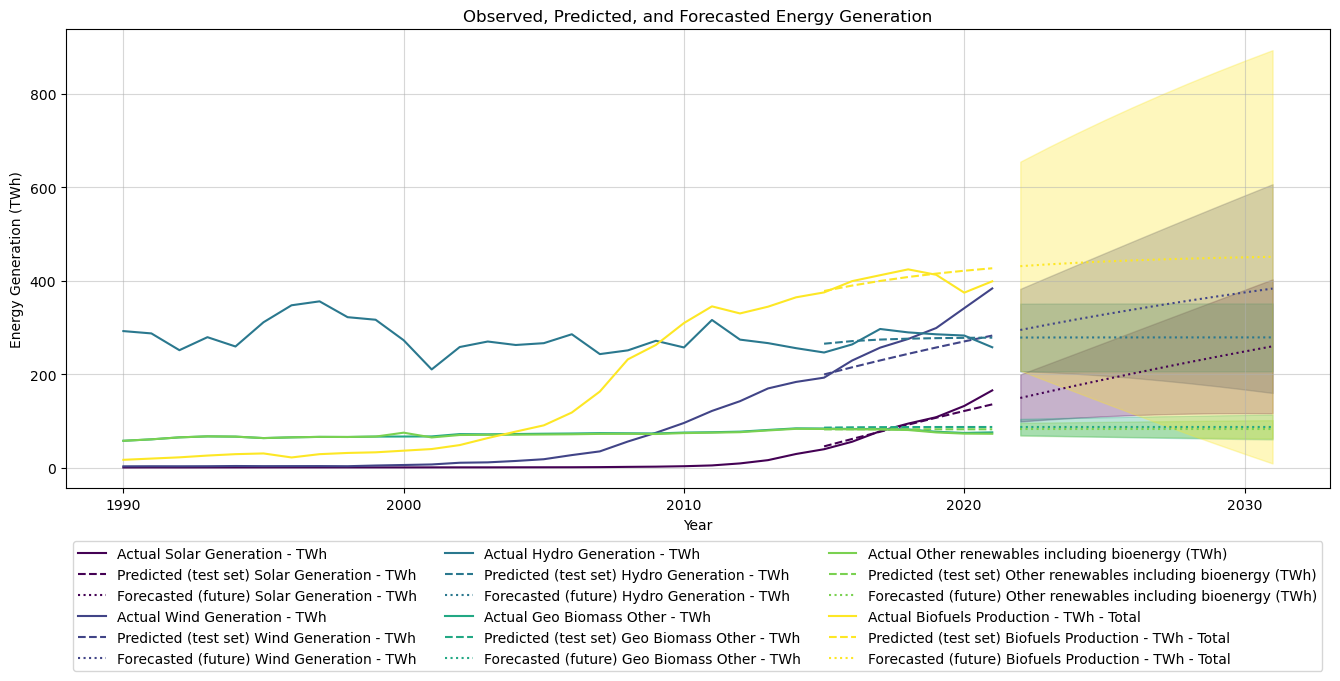

,Energy Source,MAE,RMSE,Last Value,Predicted Value,Percentage Change,CAGR,SSR
0,Solar Generation - TWh,8.183735,12.490858,165.356570,259.739634,57.078509,4.619268,1092.150780
1,Wind Generation - TWh,42.041567,52.105914,383.603270,383.298310,-0.079499,-0.007953,19005.183889
2,Hydro Generation - TWh,13.684069,15.186531,257.690100,278.792623,8.189109,0.790211,1614.415082
3,Geo Biomass Other - TWh,6.950010,8.035340,75.490265,87.017478,15.269801,1.431198,451.966875
4,Other renewables including bioenergy (TWh),4.111499,5.710936,72.490000,82.110912,13.272054,1.254021,228.303505
5,Biofuels Production - TWh - Total,16.928532,22.376082,398.846950,451.301071,13.151441,1.243234,3504.823456


In [7]:
# Set the ARIMA order
order = (1, 1, 1)  # Simplified order

# Set the forecast horizon
forecast_horizon = 10
split_idx = int(len(data_1990_onwards) * 0.8)  # 80-20 train-test split

# Initialize a plot
plt.figure(figsize=(18,7))

# Creating a colormap
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, len(data_1990_onwards.columns[1:]))]

# Initialize a DataFrame to store evaluation metrics
metrics_arima_no_stationary = pd.DataFrame(columns=['Energy Source', 'MAE', 'RMSE', 'Last Value',
                                           'Predicted Value', 'Percentage Change', 'CAGR', 'SSR'])

# Loop through all energy types, train the model, make forecasts, and plot the results
for idx, column in enumerate(data_1990_onwards.columns[1:]):
    # Train and test split
    train = data_1990_onwards[column][:split_idx]
    test = data_1990_onwards[column][split_idx:]
    
    # Fit the ARIMA model on training data
    model = ARIMA(train, order=order).fit()
    
    # Forecast the future values (length of the test set and beyond)
    forecast = model.get_forecast(steps=len(test) + forecast_horizon)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(test, mean_forecast.iloc[:len(test)])
    rmse = mean_squared_error(test, mean_forecast.iloc[:len(test)], squared=False)
    
    # Last observed value and predicted value for 2031
    last_value = data_1990_onwards[column].iloc[-1]
    predicted_value_2031 = mean_forecast.iloc[-1]
    
    # Growth (%) from last observed value to 2031
    growth_percent = ((predicted_value_2031 - last_value) / last_value) * 100
    
    # CAGR (%) from last observed year to 2031
    num_years = data_1990_onwards['Year'].iloc[-1] + forecast_horizon - data_1990_onwards['Year'].iloc[-1]
    cagr_percent = ((predicted_value_2031 / last_value) ** (1/num_years) - 1) * 100
    
    # SSR Calculation
    residuals = test - mean_forecast.iloc[:len(test)]
    ssr = np.sum(residuals**2)
    
    # Append evaluation metrics and percentage growth to DataFrame
    metrics_arima_no_stationary = metrics_arima_no_stationary.append({
        'Energy Source': column,
        'MAE': mae,
        'RMSE': rmse,
        'Last Value': last_value,
        'Predicted Value': predicted_value_2031,
        'Percentage Change': growth_percent,
        'CAGR': cagr_percent,
        'SSR': ssr
    }, ignore_index=True)

    
    # Plot actual, predicted, and forecasted data
    plt.plot(data_1990_onwards['Year'], data_1990_onwards[column], label=f'Actual {column}', color=colors[idx])
    plt.plot(data_1990_onwards['Year'][split_idx:], mean_forecast.iloc[:len(test)], linestyle='--', label=f'Predicted (test set) {column}', color=colors[idx])
    plt.plot(np.arange(data_1990_onwards['Year'].iloc[-1] + 1, data_1990_onwards['Year'].iloc[-1] + 1 + forecast_horizon), mean_forecast.iloc[-forecast_horizon:], linestyle=':', label=f'Forecasted (future) {column}', color=colors[idx])
    plt.fill_between(np.arange(data_1990_onwards['Year'].iloc[-1] + 1, data_1990_onwards['Year'].iloc[-1] + 1 + forecast_horizon), conf_int.iloc[-forecast_horizon:, 0], conf_int.iloc[-forecast_horizon:, 1], color=colors[idx], alpha=0.3)

# Plot
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.title('Observed, Predicted, and Forecasted Energy Generation')
plt.legend(loc='upper left', bbox_to_anchor=(0,-0.1), ncol=3)
plt.grid(True, alpha=0.5)
plt.tight_layout(rect=[0,0,0.75,1])
plt.savefig("ARIMA_I.png", dpi=300)
plt.show()

# Display metrics
metrics_arima_no_stationary

<div class="span5 alert alert-info">
    
<b>Model Performance and Insights</b>: For some energy sources, such as Solar Generation, the model appears to capture the trend but underestimates later-year values. Wind Generation shows visible deviations from the rapid increase in later years. Hydro Generation aligns well with the observed data, indicating decent predictive performance. Other sources exhibit varied performance and might benefit from further refinement.
   <br> <br>

<b>Performance Metrics</b>: Relatively high MAE and RMSE for Solar and Wind values suggest potential inaccuracies and underperformance. Conversely, Hydro and Geo Biomass generation demonstrates lower MAE and RMSE, suggesting better short-term forecast accuracy. Biofuels Production displays moderate MAE and RMSE, indicating reasonable performance with room for improvement.
    <br>
    <br>
<b>Summary</b>: Based on these results, <b>Solar</b> generation appears to have the highest predicted growth rate (57%) and CAGR (4%) over the next decade, making it a strong candidate for being the renewable energy source that will grow the most. However, similarly to the last model, it's worth noting that the widespread occurrence of a large Sum of Squared Residuals (SSR) for the Solar source suggests that this model may not be robust enough for reliable forecasting.

</div>


### Stationarity Test

The second approach involved testing for stationarity within the time series data using adfuller test. By assessing stationarity, it becomes possible to transform the data appropriately, ensuring that the underlying statistical properties, such as mean and variance, remain consistent over time. In the previous approach, the models were initially constructed using a general ARIMA(1, 0, 1) order, which were not optimal for all individual series within the analysis, potentially leading to less accurate forecasts.

In [8]:
def adf_test(series, name=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test on "{name}"')
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    if result[1] <= 0.05:
        print('Reject the null hypothesis: The time series is stationary.\n')
    else:
        print('Fail to reject the null hypothesis: The time series is non-stationary.\n')

# Perform ADF test for all energy types
adf_results = {}
energy_types = data_1990_onwards.columns
for energy in energy_types[1:]:
    print(adf_test(data_1990_onwards[energy], name=energy))

ADF Test on "Solar Generation - TWh"
ADF Statistic: 1.757
p-value: 0.998
Fail to reject the null hypothesis: The time series is non-stationary.

None
ADF Test on "Wind Generation - TWh"
ADF Statistic: -3.114
p-value: 0.026
Reject the null hypothesis: The time series is stationary.

None
ADF Test on "Hydro Generation - TWh"
ADF Statistic: -4.223
p-value: 0.001
Reject the null hypothesis: The time series is stationary.

None
ADF Test on "Geo Biomass Other - TWh"
ADF Statistic: 0.233
p-value: 0.974
Fail to reject the null hypothesis: The time series is non-stationary.

None
ADF Test on "Other renewables including bioenergy (TWh)"
ADF Statistic: 1.286
p-value: 0.997
Fail to reject the null hypothesis: The time series is non-stationary.

None
ADF Test on "Biofuels Production - TWh - Total"
ADF Statistic: 0.158
p-value: 0.970
Fail to reject the null hypothesis: The time series is non-stationary.

None


In [9]:
# ADF Test Function
def adf_test(series, name=''):
    result = adfuller(series, autolag='AIC')
    print(f'\nADF Test on "{name}"')
    print(f'  ADF Statistic: {result[0]:.3f}')
    print(f'  p-value: {result[1]:.3f}')
    print(f'  Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print('  --> Reject the null hypothesis: The time series is stationary.')
    else:
        print('  --> Fail to reject the null hypothesis: The time series is non-stationary.')

# Data transformation dictionary
# these transformations are summarized after a lot of experimentation and long code
transformations = {
    'Solar Generation - TWh': lambda x: np.log(x).diff().diff(),
    'Geo Biomass Other - TWh': lambda x: x.diff(),
    'Other renewables including bioenergy (TWh)': lambda x: x.diff(),
    'Biofuels Production - TWh - Total': lambda x: np.log(x).diff()
}

# Differenced Data & ADF Test
data_diff = pd.DataFrame(index=data_1990_onwards.index)

for col, func in transformations.items():
    transformed_data = func(data_1990_onwards[col]).dropna()
    data_diff[col] = transformed_data
    adf_test(transformed_data, name=f"{col} (Transformed)")


ADF Test on "Solar Generation - TWh (Transformed)"
  ADF Statistic: -8.936
  p-value: 0.000
  Critical Values: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}
  --> Reject the null hypothesis: The time series is stationary.

ADF Test on "Geo Biomass Other - TWh (Transformed)"
  ADF Statistic: -4.126
  p-value: 0.001
  Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
  --> Reject the null hypothesis: The time series is stationary.

ADF Test on "Other renewables including bioenergy (TWh) (Transformed)"
  ADF Statistic: -3.967
  p-value: 0.002
  Critical Values: {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}
  --> Reject the null hypothesis: The time series is stationary.

ADF Test on "Biofuels Production - TWh - Total (Transformed)"
  ADF Statistic: -3.888
  p-value: 0.002
  Critical Values: {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.62117111111111

 The first-order differencing made **Geo Biomass** and **Other renewables**  series stationary. However, **Solar** and **Biofuels Production** remain non-stationary. After a first-order differencing, they also remain stationary. After log-transformaiton, the **Biofuels** becomes stationary, and after a second-order differencing, the **Solar** becomes stationary.

### ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) 

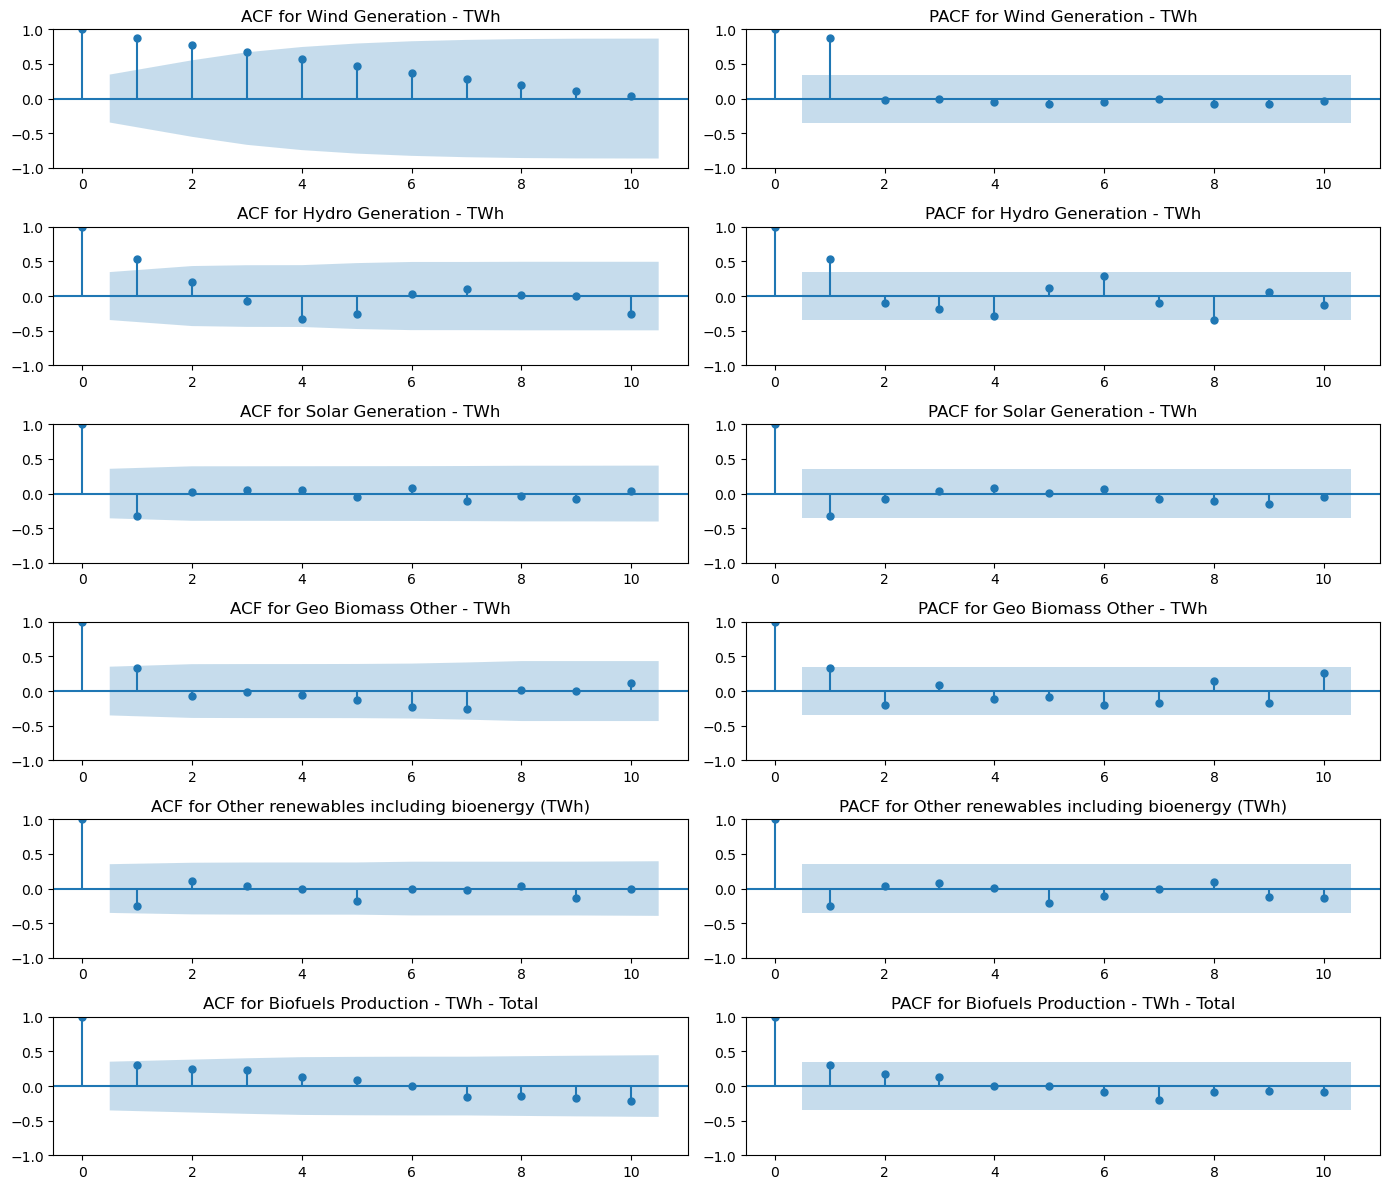

In [10]:
# Data transformation dictionary
transformations = {
    'Wind Generation - TWh': lambda x: x,
    'Hydro Generation - TWh': lambda x: x,
    'Solar Generation - TWh': lambda x: np.log(x).diff().diff(),
    'Geo Biomass Other - TWh': lambda x: x.diff(),
    'Other renewables including bioenergy (TWh)': lambda x: x.diff(),
    'Biofuels Production - TWh - Total': lambda x: np.log(x).diff()
}

# Plotting ACF and PACF for Transformed Series
fig, axs = plt.subplots(len(transformations), 2, figsize=(14, 2*len(transformations)))

for i, (col, func) in enumerate(transformations.items()):
    transformed_data = func(data_1990_onwards[col]).dropna()
    
    # ACF Plot
    sm.graphics.tsa.plot_acf(transformed_data, lags=10, ax=axs[i, 0])
    axs[i, 0].set_title(f'ACF for {col}')
    
    # PACF Plot
    sm.graphics.tsa.plot_pacf(transformed_data, lags=10, ax=axs[i, 1], method='ywm')
    axs[i, 1].set_title(f'PACF for {col}')
    
# Adjusting layout for better readability
plt.tight_layout()
plt.savefig("ACF.png", dpi=300)
plt.show()

<div class="span5 alert alert-info">
<b>ACF and PACF Analysis</b>: Analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for each energy source, we can discern potential model orders:
<ul>
<li><b>Solar Generation - TWh</b>: The PACF has a sharp cut-off at lag 2, and the ACF decays gradually, suggesting an AR(2) model might be suitable.
<li><b>Geo Biomass Other - TWh</b>: The ACF has a sharp cut-off at lag 1, indicating an MA(1) model might be suitable.
<li><b>Other Renewables including Bioenergy - TWh</b>: The PACF has a sharp cut-off at lag 1, suggesting an AR(1) model might be appropriate.
<li><b>Biofuels Production - TWh - Total</b>: The PACF has a sharp cut-off at lag 1, while the ACF decays gradually, suggesting an AR(1) model might be suitable.
<li><b>Wind Generation - TWh</b>: The ACF and PACF do not show a clear cut-off, which might indicate that an ARMA model could be suitable. Further investigation and model selection criteria like AIC might be helpful to decide on the order.
<li><b>Hydro Generation - TWh</b>: The ACF shows a gradual decay, while PACF has a cut-off at lag 2, suggesting an AR(2) model might be appropriate.
</ul>
</div>

## MODEL 2b: ARIMA (stationary series) 

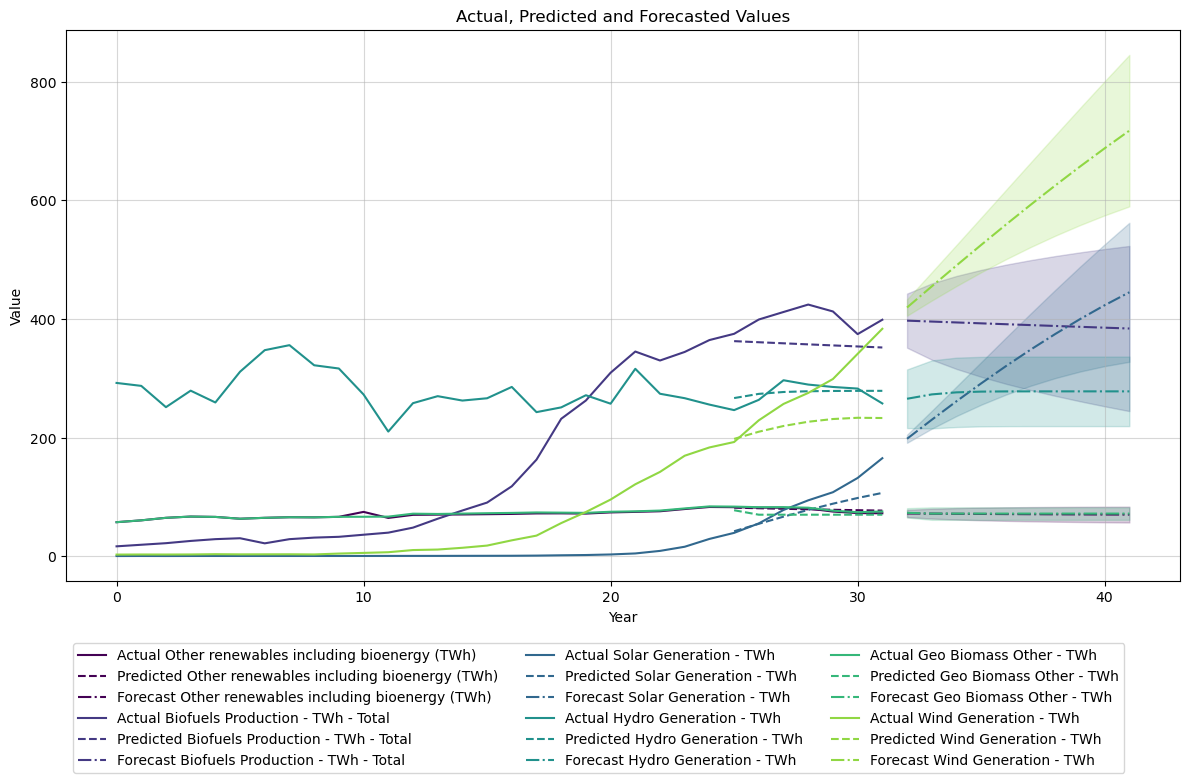

,Energy Source,MAE,RMSE,Last Value,Predicted Value,Percentage Change,CAGR,SSR
0,Other renewables including bioenergy (TWh),2.469155,2.925344,83.070000,81.963214,-1.332353,-0.134041,59.903467
1,Biofuels Production - TWh - Total,42.205671,46.003152,364.588200,362.744190,-0.505779,-0.050693,14814.030211
2,Solar Generation - TWh,20.366277,27.614764,29.216162,42.168872,44.334057,3.737764,5338.026391
3,Hydro Generation - TWh,13.330177,14.858827,255.750580,266.754527,4.302609,0.422150,1545.493221
4,Geo Biomass Other - TWh,8.538493,9.202109,84.070230,77.585390,-7.713599,-0.799521,592.751724
5,Wind Generation - TWh,62.298381,78.345524,183.490190,197.912109,7.859777,0.759488,42966.147860


In [11]:
# Define ARIMA orders
orders = {
    "Other renewables including bioenergy (TWh)": (1, 0, 0),
    "Biofuels Production - TWh - Total": (1, 0, 0),
    "Solar Generation - TWh": (2, 0, 0),
    "Hydro Generation - TWh": (2, 0, 0),
    "Geo Biomass Other - TWh": (0, 0, 1),
    "Wind Generation - TWh": (2, 0, 1)
}

# Forecast horizon
forecast_horizon = 10

# Placeholder for metrics
metrics_arima_stationary = pd.DataFrame(columns=["Energy Source", "MAE", "RMSE", "Last Value", "Predicted Value", 
                                           "Percentage Change", "CAGR", "SSR"])

# Plot setup
plt.figure(figsize=(16,8))

# Loop through columns, fit the model, forecast, and calculate metrics
for idx, (col, order) in enumerate(orders.items()):
    # Train/test split
    data = data_1990_onwards[col]
    train_size = int(len(data) * 0.8)
    train, test = data[0:train_size], data[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train, order=order).fit()
    
    # Predict and calculate metrics
    predictions = model.forecast(steps=len(test))
    mae = mean_absolute_error(test, predictions)
    rmse = mean_squared_error(test, predictions, squared=False)
    last_value = train.iloc[-1]
    predicted_value = predictions.iloc[0]
    percentage_change = ((predicted_value - last_value) / abs(last_value)) * 100
    cagr = ((predicted_value / last_value) ** (1/forecast_horizon) - 1) * 100
    ssr = sum((predictions - test) ** 2)
    
    # Store metrics
    metrics_arima_stationary = metrics_arima_stationary.append({
        "Energy Source": col,
        "MAE": mae,
        "RMSE": rmse,
        "Last Value": last_value,
        "Predicted Value": predicted_value,
        "Percentage Change": percentage_change,
        "CAGR": cagr,
        "SSR": ssr
    }, ignore_index=True)
    
    # Make forecasts for the next 10 years and obtain confidence intervals
    model_full = ARIMA(data, order=order).fit()
    future_forecast = model_full.get_forecast(steps=forecast_horizon)
    forecast_future = future_forecast.predicted_mean
    conf_int = future_forecast.conf_int()
    
    # Plot actual, predicted, and forecasted data
    color = plt.cm.viridis(idx/len(orders))
    plt.plot(data.index, data, label=f'Actual {col}', color=color)
    plt.plot(data.index[-len(predictions):], predictions, label=f'Predicted {col}', linestyle='--', color=color)
    plt.plot(pd.RangeIndex(start=data.index[-1]+1, stop=data.index[-1]+1+forecast_horizon), forecast_future, 
             label=f'Forecast {col}', linestyle='-.', color=color)
    plt.fill_between(pd.RangeIndex(start=data.index[-1]+1, stop=data.index[-1]+1+forecast_horizon), 
                     conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=color, alpha=0.2)

# Plot
plt.title('Actual, Predicted and Forecasted Values')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True, alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(0,-0.1), ncol=3)
plt.tight_layout(rect=[0,0,0.75,1])
plt.savefig("ARIMA2.png", dpi=300)
plt.show()

# Display metrics
metrics_arima_stationary

<div class="span5 alert alert-info">
    
<b>Model Performance and Insights</b>: Solar, Hydro and Wind predict a notable increase in  generation over the next decade; Other renewables, Biofuels Production, and Geo Biomass Other are predicted to decrease slightly or remain relatively stable.
<br> <br> 
<b>Performance Metrics</b>: Relatively high MAE and RMSE for Solar, Wind, and Biofuels values might indicate that the model does not fit the data as well as for other energy types. However, the low MAE and RMSE for Other renewables, Hydro, Geo Biomass suggest that the model fits the data well, and thus, the forecast might be reliable 
    <br>
    <br>
<b>Summary</b>: Based on these results, <b>Solar</b> generation appears to have the highest predicted growth rate (44 %) and CAGR (3.74%) over the next decade, making it a strong candidate for being the renewable energy source that will grow the most. However, similarly to the last model, it's worth noting that the widespread occurrence of a large Sum of Squared Residuals (SSR) for the Solar source suggests that this model may not be robust enough for reliable forecasting.

</div>

---

## MODEL 3: LSTM

2023-10-15 15:45:49.718477: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 9ms/step


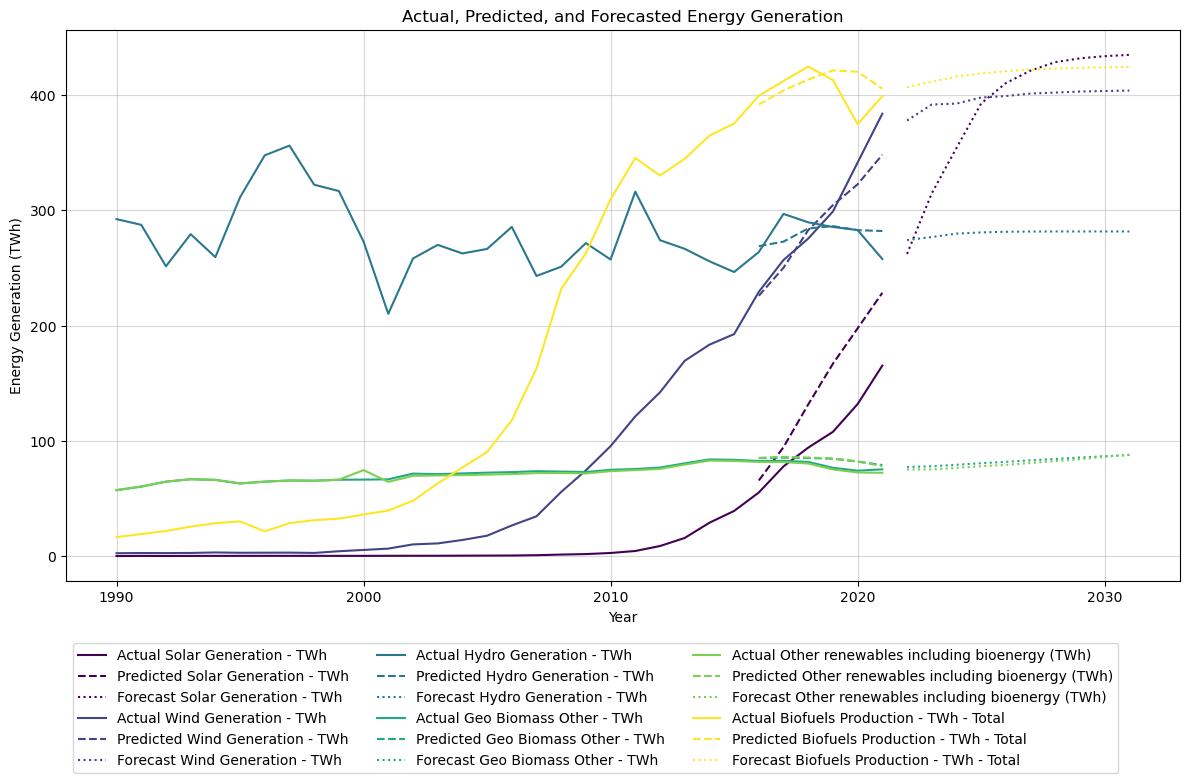

,Energy Source,MAE,RMSE,Last Value,Predicted Value,Percentage Change,CAGR,SSR
0,Solar Generation - TWh,42.031135,47.526211,165.356570,228.442245,38.151297,3.284582,13552.444488
1,Wind Generation - TWh,12.893097,17.125643,383.603270,348.067078,-9.263788,-0.967427,1759.725885
2,Hydro Generation - TWh,9.910003,14.257991,257.690100,281.960022,9.418259,0.904139,1219.741858
3,Geo Biomass Other - TWh,4.708372,5.232665,75.490265,79.168358,4.872274,0.476863,164.284703
4,Other renewables including bioenergy (TWh),6.332277,6.757752,72.490000,78.270737,7.974530,0.770203,274.003282
5,Biofuels Production - TWh - Total,14.527251,20.081975,398.846950,405.265198,1.609201,0.159767,2419.714418


In [12]:
# Parameters
look_back = 3
forecast_horizon = 10

# Initialize DataFrame for metrics
metrics_LSTM = pd.DataFrame(columns=["Energy Source", "MAE", "RMSE", "Last Value", "Predicted Value", "Percentage Change", "CAGR", "SSR"])

# Initialize a single plot for all energy sources
plt.figure(figsize=(16,8))

# Create a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data_1990_onwards.columns[1:])))

# Loop through each energy source
for idx, col in enumerate(data_1990_onwards.columns[1:]):
    
    # Extract and scale the data
    data = data_1990_onwards[[col]].values.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create datasets
    X, y = [], []
    for i in range(len(data_scaled) - look_back):
        X.append(data_scaled[i:(i + look_back), 0])
        y.append(data_scaled[i + look_back, 0])
    X = np.array(X)
    y = np.array(y)
    
    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
    # Train/test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[0:train_size, :], X[train_size:len(X), :]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]
    
    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
    
    # Predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])
    
    # Calculate metrics
    mae = mean_absolute_error(y_test[0], test_predict[:,0])
    rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
    
    # Additional metrics
    last_value = data[-1, 0]
    predicted_value = test_predict[-1, 0]
    percentage_change = ((predicted_value - last_value) / abs(last_value)) * 100
    cagr = ((predicted_value/last_value)**(1/forecast_horizon) - 1) * 100
    
    # Forecasting for the next 10 years
    future_forecast = np.array(data_scaled[-look_back:, 0])
    for _ in range(forecast_horizon):
        future_forecast_input = future_forecast[-look_back:].reshape((1, 1, look_back))
        future_forecast_output = model.predict(future_forecast_input)[0, 0]
        future_forecast = np.append(future_forecast, future_forecast_output)
    
    # Invert scaling
    future_forecast = scaler.inverse_transform(future_forecast.reshape(-1, 1))
    
    # SSR
    residuals = y_test[0] - test_predict[:,0]
    ssr = np.sum(residuals**2)

    # Add metrics to DataFrame
    metrics_LSTM = metrics_LSTM.append({
        "Energy Source": col,
        "MAE": mae,
        "RMSE": rmse,
        "Last Value": last_value,
        "Predicted Value": predicted_value,
        "Percentage Change": percentage_change,
        "CAGR": cagr,
        "SSR": ssr
    }, ignore_index=True)
    
    # Plot actual, predicted, and forecasted data
    plt.plot(data_1990_onwards['Year'], data, label=f'Actual {col}', color=colors[idx])
    plt.plot(data_1990_onwards['Year'][-len(test_predict):], test_predict, label=f'Predicted {col}', linestyle='--', color=colors[idx])
    future_years = np.arange(data_1990_onwards['Year'].iloc[-1] + 1, data_1990_onwards['Year'].iloc[-1] + 1 + forecast_horizon)
    plt.plot(future_years, future_forecast[-forecast_horizon:], label=f'Forecast {col}', linestyle=':', color=colors[idx])

# Plotting
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.title('Actual, Predicted, and Forecasted Energy Generation')
plt.legend(loc='upper left', bbox_to_anchor=(0,-0.1), ncol=3)
plt.grid(True, alpha=0.5)
plt.tight_layout(rect=[0,0,0.75,1])
plt.savefig("lstm.png", dpi=300)
plt.show()

# Display metrics
metrics_LSTM

<div class="span5 alert alert-info">
    
<b>Model Performance and Insights</b>: Solar Generation, though exhibiting a consistent upward trend, appears to be underestimated by the model. Wind Generation, conversely, shows a slight overestimation in the latter years, while Hydro Generation’s predicted values align relatively well with actual data, indicating commendable model performance. Other energy types demonstrate varying performances and may benefit from further model optimization.
<br>
<br>
<b>Performance Metrics</b>: The model performance metrics are diverse across the different energy sources. Solar Generation displays relatively high MAE and RMSE values, suggesting potential underestimation in the forecasts. Wind Generation also shows considerable MAE and RMSE, indicating potential model overfitting. In contrast, Hydro Generation demonstrates lower MAE and RMSE values, hinting at more accurate short-term forecast performance. Geo Biomass and Other Renewables also exhibit relatively lower MAE and RMSE, which is a promising sign, whereas Biofuels Production portrays moderate MAE and RMSE, indicating a reasonable but improvable performance.
<br>
<br>
<b>Summary</b>: Based on these results, <b>Solar</b> generation appears to have the highest predicted growth rate 25.2%) and CAGR (2.2%) over the next decade, making it a strong candidate for being the renewable energy source that will grow the most.

</div>


---

## Final considerations

The final metric table provides predictions for various types of renewable energy sources using different modeling techniques (Linear Regression, ARIMA, and LSTM). Where the colums are:

* **Energy Source**: The type of renewable energy.
* **MAE**: Mean Absolute Error of the model prediction. It measures the average magnitude of the errors between predicted and observed values, without considering their direction.
* **RMSE**: Root Mean Squared Error of the model prediction. It measures the square root of the average squared differences between predicted and observed outcomes.
* **Last Value**: The most recent actual value recorded for the energy source.
* **Predicted Value**: The value predicted by the model for a future period.
* **Percentage Change**: The percentage change from the "Last Value" to the "Predicted Value".
* **CAGR**: Compound Annual Growth Rate, representing the mean annual growth rate of the growth over a specified time period longer than one year.
* **SSR**: Sum of Squared Residuals, a measure of the discrepancy between the data and an estimation model.
* **Model**: The type of statistical model used to make the prediction (Linear Regression, ARIMA, or LSTM).

In [13]:
# Adding a 'Model' column to each DataFrame to indicate the model type
metrics_linear['Model'] = 'Linear Regression'
metrics_arima_no_stationary['Model'] = 'ARIMA Non-Stationary'
metrics_arima_stationary['Model'] = 'ARIMA Stationary'
metrics_LSTM['Model'] = 'LSTM'

# Concatenating all the DataFrames into one
all_metrics = pd.concat([
    metrics_linear,
    metrics_arima_no_stationary,
    metrics_arima_stationary,
    metrics_LSTM
], axis=0, ignore_index=True)

all_metrics


all_metrics.to_csv('all_metrics.csv', index=False)


### What is the best model?

To answer this question, I evaluate the Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Sum of Squared Residuals (SSR) across the different models (Linear Regression, ARIMA Non-Stationary, ARIMA Stationary, and LSTM) used to predict the energy generation for each energy source. 

A common approach to model selection involves choosing the model that minimizes error metrics like MAE, RMSE, and SSR. Lower values for these metrics typically indicate a better-fitting model, assuming that the model is not overfitting the data.

Firstly, I calculate the median MAE, RMSE, and SSR for each model type. Then, I selected the model type that minimizes these metrics.

In [15]:
# Calculating the median MAE, RMSE, and SSR for each model type
model_metrics = all_metrics.groupby("Model").agg({
    "MAE": "median",
    "RMSE": "median",
    "SSR": "median"
})

# Identifying the model type with the smallest median MAE, RMSE, and SSR
best_model = model_metrics.idxmin().mode().iloc[0]

best_model, model_metrics.sort_values(by=["MAE", "RMSE", "SSR"])


('ARIMA Non-Stationary',
                             MAE       RMSE           SSR
 Model                                                   
 ARIMA Non-Stationary  10.933902  13.838695   1353.282931
 LSTM                  11.401550  15.691817   1489.733871
 ARIMA Stationary      16.848227  21.236796   3441.759806
 Linear Regression     59.336141  68.140643  35894.222450)

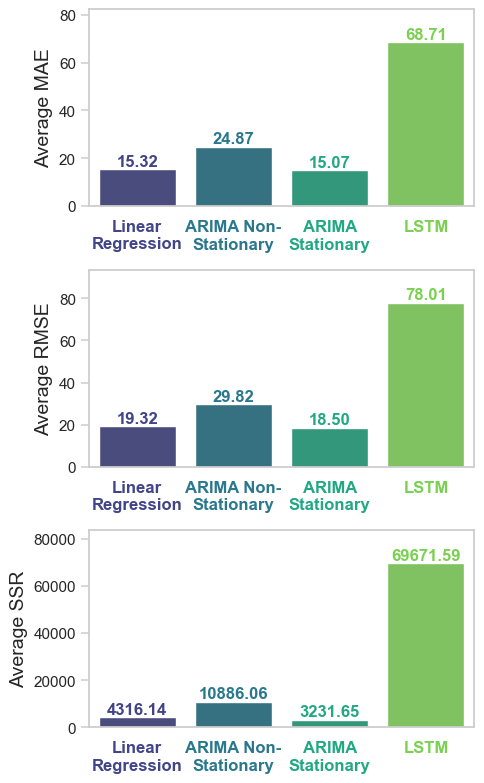

In [62]:
# Calculating average MAE, RMSE, and SSR per model type
average_errors_per_model = all_metrics.groupby('Model')[['MAE', 'RMSE', 'SSR']].mean().reset_index()

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating subplots with adjusted y-axis limits
fig, ax = plt.subplots(3, 1, figsize=(5, 8))

# List of metrics and corresponding axis labels and titles
metrics = ['MAE', 'RMSE', 'SSR']
ylabels = ['Average MAE', 'Average RMSE', 'Average SSR']
# List of new x-axis labels with line breaks
xlabels = ['Linear\nRegression', 'ARIMA Non-\nStationary', 'ARIMA\nStationary', 'LSTM']
titles = ['Average MAE per Model Type', 'Average RMSE per Model Type', 'Average SSR per Model Type']

# Defining the color palette
palette = sns.color_palette("viridis", n_colors=len(average_errors_per_model['Model']))

# Plotting bar chart for average MAE, RMSE, and SSR per model type
for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=average_errors_per_model, ax=ax[i], palette=palette)
    ax[i].set_xlabel(None, fontsize=14)
    ax[i].set_ylabel(ylabels[i], fontsize=14)
    
    # Setting new x-axis labels
    ax[i].set_xticklabels(xlabels, fontsize=12, weight='bold')  # Removed the color parameter here
    
    # Adjusting y-axis limits to make sure that the text fits well
    ax[i].set_ylim(0, 1.2 * max(average_errors_per_model[metric]))
    
    # Adding the text labels in each bar
    for j, value in enumerate(average_errors_per_model[metric]):
        ax[i].text(j, value + 0.02 * max(average_errors_per_model[metric]), f'{value:.2f}', 
                   color=palette[j], ha="center", fontsize=12, weight='bold')
        
    # Coloring the x-axis labels to match the bars
    for j, label in enumerate(ax[i].get_xticklabels()):
        label.set_color(palette[j])
        label.set_fontweight('bold')
        
    ax[i].yaxis.grid(False)
    ax[i].tick_params(axis='y', which='both', left=True, color='lightgray')
    

# Adjusting layout
plt.tight_layout()
plt.savefig("model_eval.png", dpi=300)
plt.show()


The model that seems to perform the best, based on having the lowest median values for MAE, RMSE, and SSR, is the **ARIMA Non-Stationary** model. 

### What is the renewable energy resource that will grow the most in the next decade?

In [16]:
# Filtering the data to only include predictions from the ARIMA Non-Stationary model
arima_ns_df = all_metrics[all_metrics["Model"] == "ARIMA Non-Stationary"]

# Identifying the row with the highest Percentage Change in the ARIMA Non-Stationary model DataFrame
max_growth_arima_ns_row = arima_ns_df.loc[arima_ns_df["Percentage Change"].idxmax()]

max_growth_arima_ns_row

Energy Source        Solar Generation - TWh
MAE                                8.183735
RMSE                              12.490858
Last Value                        165.35657
Predicted Value                  259.739634
Percentage Change                 57.078509
CAGR                               4.619268
SSR                              1092.15078
Model                  ARIMA Non-Stationary
Name: 6, dtype: object

Within the **ARIMA Non-Stationary** model, the renewable energy source projected to grow the most in the next decade is **Solar** generation. 

<div class="span5 alert alert-info">
    
<b>Final remarks for this dataset</b>
<ul>
    <li> <b>What is the best model for this dataset?</b> ARIMA Non-Stationary
    <li> <b>What is the renewable energy resource that will grow the most in the next decade?</b> Solar energy
    </ul>
</div>